# Assignment 5: Neural Networks

Due: November 6th at 11:59pm

### Prashant K Thakur

## Exploring neural networks for digit classification 

In this assignment you will explore classification of handwritten digits with neural networks. For that task, we will use part of the MNIST dataset, which is very commonly used in the machine learning community. Your task is to explore various aspects of multi-layer neural networks using this dataset. We have prepared a [small subset](http://www.cs.colostate.edu/~cs545/fall16/lib/exe/fetch.php?media=assignments:mnist.tar.gz) of the data with a given split into training and test data.

1. Plot network accuracy as a function of the number of hidden units for a single-layer network with a logistic activation function. Try to find a range of values where the network displays both under-fitting and over-fitting.  For a fixed architecture, explore accuracy as a function of the number of epochs used for training as well as the learning rate.
2. Plot network accuracy as a function of the number of hidden units for a two-layer network with a logistic activation function, similarly to part 1 using a specific value of the learning rate and number of epochs. Does this dataset benefit from the use of more than one layer?
3.  Add weight decay regularization to the neural network class (explain in your report how you did it). Does the network demonstrate less over-fitting on this dataset with the addition of weight decay?
4. Modify the code to include the option of using the cross-entropy loss function instead of the quadratic loss function.  Run experiments and determine which activation function works best with the cross-entropy (consider logistic and ReLU activations for the hidden layers).  Explain in your writeup the required changes in the code.
5. The code provided performs batch gradient descent.  Modify the code to perform stochastic gradient descent.  Explain in your report the change you made, and compare the performance of the resulting network in terms of accuracy and training time.
6. The provided implementation uses the same activation function in each layer. For solving regression problems we need to use a linear activation function to produce the output of the network. Explain why, and what changes need to be made in the code.


In [55]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# the common activation functions:

def logistic(x):
    return 1/(1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)

# and their derivatives:

def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2

def logistic_deriv(x):
    return logistic(x)*(1-logistic(x))

def relu_deriv(x) :
    deriv = x.copy()
    deriv[deriv < 0] = 0
    return deriv


class NeuralNetwork :
    def __init__(self, architecture, activation='logistic') :
        self.architecture = architecture
        if activation == 'logistic':
            self.activation = logistic
            self.activation_deriv = logistic_deriv
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_deriv = tanh_deriv
        elif activation == 'relu':
            self.activation = relu
            self.activation_deriv = relu_deriv
        else :
            raise ValueError('Activation does not match options')
        self.initialize_weights()
        
    def initialize_weights(self) :
        W = {}
        b = {}
        for l in range(1, len(self.architecture)):
            W[l] = np.random.random((self.architecture[l], self.architecture[l-1]))*np.sqrt(1/(self.architecture[0]+self.architecture[-1]))
            b[l] = np.random.random((self.architecture[l],))
            #W[l] = np.random.randn(self.architecture[l], self.architecture[l-1])
            #b[l] = np.random.randn(self.architecture[l])
        self.W, self.b = W, b

    def forward(self, x):
        h = {1: x}
        s = {}
        for l in range(1, len(self.W) + 1):
            s[l+1] = self.W[l].dot(h[l]) + self.b[l]
            h[l+1] = self.activation(s[l+1])
        return h, s
        
    def init_delta_values(self):
        delta_W = {}
        delta_b = {}
        for l in range(1, len(self.architecture)):
            delta_W[l] = np.zeros((self.architecture[l], self.architecture[l-1]))
            delta_b[l] = np.zeros((self.architecture[l],))
        return delta_W, delta_b

    def calculate_output_layer_delta(self, y, h_out, s_out):
        return -(y-h_out) * self.activation_deriv(s_out)
    
    def calculate_output_layer_delta_xentropy(self, y, h_out, s_out):
        return -np.sum(y/h_out+1e-17) * logistic_deriv(s_out)

    def calculate_hidden_delta(self, delta_plus_1, w_l, s_l):
        # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(s^(l))
        return np.dot(np.transpose(w_l), delta_plus_1) * self.activation_deriv(s_l)

    def fit(self, X, y, num_iterations=3000, alpha=0.5,lambd=0.0007,xentropy=False,stocastic=False):
        iterations = 0
        N = len(y)
        avg_cost_func = []
        print('Starting gradient descent for {} iterations'.format(num_iterations))
        while iterations < num_iterations :
#             if iterations%(200) == 0: # For testing the code
            if iterations%(num_iterations-1) == 0:
#                 print('Iteration {} of {}'.format(iterations, num_iterations))
                if len(avg_cost_func) > 0:
                    print('Final Cost: ', avg_cost_func[-1])
            delta_W, delta_b = self.init_delta_values()
            avg_cost = 0
            if stocastic:
                idx=np.random.permutation(range(len(X)))
                X=X[idx]
                y=y[idx]
                
            for i in range(len(y)):
                delta = {}
                # perform the feed forward pass and return the stored h and z values, to be used in the
                # gradient descent step
                h, s = self.forward(X[i, :])
                # backpropagate the errors
                for l in range(len(self.architecture), 0, -1):
                    if l == len(self.architecture):
                        if xentropy:
                            delta[l] = self.calculate_output_layer_delta_xentropy(y[i,:], h[l], s[l])
                        else:
                            delta[l] = self.calculate_output_layer_delta(y[i,:], h[l], s[l])
                        avg_cost += (np.linalg.norm((y[i,:]-h[l])) / N)
                    else:
                        if l > 1:
                            delta[l] = self.calculate_hidden_delta(delta[l+1], self.W[l], s[l])

                        if stocastic:
                            delta_W[l] = np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis]))
                            delta_b[l] = delta[l+1]
                            self.W[l] += -alpha * delta_W[l] - lambd*self.W[l]
                            self.b[l] += -alpha * delta_b[l]
                        else:
                            delta_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis]))
                            delta_b[l] += delta[l+1]
                            
            if not stocastic:
                # perform the gradient descent step for the weights in each layer
                for l in range(len(self.architecture) - 1, 0, -1):
                    self.W[l] += -alpha * (1.0/N * delta_W[l]) - lambd*self.W[l]
                    self.b[l] += -alpha * (1.0/N * delta_b[l])
            # complete the average cost calculation
            avg_cost_func.append(avg_cost)
            iterations += 1
        return avg_cost_func

    def predict(self, X):
        N = X.shape[0]
        y = np.zeros((N,))
        for i in range(N):
            h, _ = self.forward(X[i, :])
            y[i] = np.argmax(h[len(self.architecture)])
        return y

    def decision_function(self, X):
        N = X.shape[0]
        scores = np.zeros((N,self.architecture[-1]))
        for i in range(N):
            h, _ = self.forward(X[i, :])
            scores[i]=h[len(self.architecture)]
        return scores



In [35]:
def mnist_loader():
    X_train = np.genfromtxt("MNIST_train.csv", delimiter=",")
    X_test = np.genfromtxt("MNIST_test.csv", delimiter=",")
    Y_train = np.genfromtxt("MNIST_train_labels.csv", delimiter=",")
    Y_test = np.genfromtxt("MNIST_test_labels.csv", delimiter=",")
    return X_train,Y_train,X_test,Y_test

In [36]:
def train_nn(hidden_layers,lamd,iterations=[1600],alpha=[0.25],activation='logistic',xentropy=False,stocastic=False):
    X_train,y_train,X_test,y_test = mnist_loader()
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.metrics import accuracy_score
    from sklearn import preprocessing
    y_vec_train=LabelBinarizer().fit_transform(y_train)
    X_ntrain=preprocessing.scale(X_train)
    X_ntest=preprocessing.scale(X_test)
    X_ntrain = np.hstack((np.ones((X_ntrain.shape[0],1)),X_ntrain))
    X_ntest = np.hstack((np.ones((X_ntest.shape[0],1)),X_ntest))
    test_acc=[]
    INPUT_LAYER=785
    OUTPUT_LAYER=10
    train_acc=[]
    for i in hidden_layers:
        if isinstance(i,int):
            architecture = [INPUT_LAYER,i, OUTPUT_LAYER]
        if isinstance(i,tuple):
            architecture = [INPUT_LAYER,i[0],i[1], OUTPUT_LAYER]
        print("Training layers: ", architecture)
        network = NeuralNetwork(architecture, activation)
        if len(alpha) >1:
            for lrate in alpha:
                print("Training for learning rate: ",lrate)
                cost_func = network.fit(X_ntrain, y_vec_train, num_iterations=iterations[0],alpha=lrate,lambd=lamd,xentropy=xentropy,stocastic=stocastic)
                y_pred = network.predict(X_ntest)
                y_pd = network.predict(X_ntrain)
                test_acc.append(accuracy_score(y_test, y_pred))
                train_acc.append(accuracy_score(y_train, y_pd))
#                 return train_acc,test_acc
                                 
        elif len(iterations) >1:
            for itera in ITERATIONS:
                architecture = [INPUT_LAYER,50, OUTPUT_LAYER]
                print("Training layers for: ",itera)
                cost_func = network.fit(X_ntrain, y_vec_train, num_iterations=itera,alpha=alpha[0],xentropy=xentropy,lambd=lamd,stocastic=stocastic)
                y_pred = network.predict(X_ntest)
                y_pd = network.predict(X_ntrain)
                test_acc.append(accuracy_score(y_test, y_pred))
                train_acc.append(accuracy_score(y_train, y_pd))
#                 return train_acc,test_acc
        else:
            cost_func = network.fit(X_ntrain, y_vec_train, num_iterations=iterations[0],alpha=alpha[0],xentropy=xentropy,lambd=lamd,stocastic=stocastic)
            y_pred = network.predict(X_ntest)
            y_pd = network.predict(X_ntrain)
#             print("Test UNIQ: ",np.unique(y_pred))
#             print("Train UNIQ: ",np.unique(y_pd))
            test_acc.append(accuracy_score(y_test, y_pred))
            train_acc.append(accuracy_score(y_train, y_pd))
#             print("Train ACC: ",accuracy_score(y_train,y_pd))
#             print("Test ACC: ",test_acc[-1])
    return train_acc, test_acc

#### 1. Plot network accuracy as a function of the number of hidden units for a single-layer network with a logistic activation function. Try to find a range of values where the network displays both under-fitting and over-fitting. For a fixed architecture, explore accuracy as a function of the number of epochs used for training as well as the learning rate.

##### Answer:

The following sections was run to test the accuracy for a single-layer network with a logistic activation function. Different range of hidden layers were used and the accuracy for different hidden layers is plotted below. The hidden layer for 50 was able to achieve the accuracy of 86% and the accuracy seems to be constant at 86% for most of the increasing hidden layers. So the graph shows that the 50 hidden layers was able to capture most of the information from the data. 

As we can see from the accuracy vs hidden layer graph, the model is underfitting as the model is performing very poorly to capture the information in the data to relate to the corresponding label.The overfitting was not observed in the model for different hidden layers. But if higher numbers of nodes in the hidden layers were to train the model, the accuracy for the train dataset would have been higher around 99-100% and the test accuracy would have been very poor. The train accuracy was observed to around 99% but the test accuracy doesn't decrease drastically (almost it stayes at 87%) which means the model was kind of behaving similar for different hidden layers between 50-250 hidden units in the single hidden layer. Because of the time taken to train the model only these random hidden units were trained and overfitting was not noticeable.

Similarly, the accuracy with 50 hidden nodes in the single layer was tested with different number of epochs and learning rate. The following section shows the graph of how the accuracy changes with these parameters.

In [43]:
hidden_layers = [2,10,50,100,150,200,250]
train_acc1, test_acc1 = train_nn(hidden_layers,lamd=0,iterations=[2000],activation='logistic')
print(train_acc1,test_acc1)

Training layers:  [785, 2, 10]
Starting gradient descent for 2000 iterations
Training layers:  [785, 10, 10]
Starting gradient descent for 2000 iterations
Training layers:  [785, 50, 10]
Starting gradient descent for 2000 iterations
Training layers:  [785, 100, 10]
Starting gradient descent for 2000 iterations
Training layers:  [785, 150, 10]
Starting gradient descent for 2000 iterations
Training layers:  [785, 200, 10]
Starting gradient descent for 2000 iterations
Training layers:  [785, 250, 10]
Starting gradient descent for 2000 iterations
[0.205, 0.874, 0.948, 0.946, 0.947, 0.945, 0.946] [0.19, 0.796, 0.86, 0.866, 0.86, 0.86, 0.868]


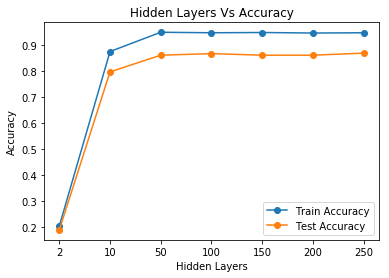

In [44]:
plt.plot(train_acc1, 'o-',label="Train Accuracy")
plt.plot(test_acc1, 'o-',label="Test Accuracy")
plt.legend()
plt.xticks(range(len(hidden_layers)),hidden_layers)
plt.xlabel("Hidden Layers")
plt.ylabel("Accuracy")
plt.title("Hidden Layers Vs Accuracy");

In [33]:
hidden_layers2 = [1000]
train_acc_1, test_acc_1 = train_nn(hidden_layers2,lamd=0,iterations=[1500],activation='logistic')
print(train_acc_1,test_acc_1)

Training layers:  [785, 1000, 10]
Starting gradient descent for 1500 iterations
[0.47] [0.428]


* Exploring accuracy for different learning rate.

In [45]:
LEARNING_RATE=[0.001,0.01,0.1,0.25,0.5,0.75,1,10,100]
train_acc2, test_acc2 = train_nn([50],lamd=0,iterations=[1600],activation='logistic',alpha=LEARNING_RATE)
print(train_acc2,test_acc2)

Training layers:  [785, 50, 10]
Training for learning rate:  0.001
Starting gradient descent for 1600 iterations
Training for learning rate:  0.01
Starting gradient descent for 1600 iterations
Training for learning rate:  0.1
Starting gradient descent for 1600 iterations
Training for learning rate:  0.25
Starting gradient descent for 1600 iterations
Training for learning rate:  0.5
Starting gradient descent for 1600 iterations
Training for learning rate:  0.75
Starting gradient descent for 1600 iterations
Training for learning rate:  1
Starting gradient descent for 1600 iterations
Training for learning rate:  10
Starting gradient descent for 1600 iterations
Training for learning rate:  100
Starting gradient descent for 1600 iterations
[0.1, 0.096, 0.307, 0.965, 0.987, 0.991, 0.992, 0.992, 0.994] [0.1, 0.108, 0.286, 0.876, 0.876, 0.874, 0.874, 0.872, 0.87]


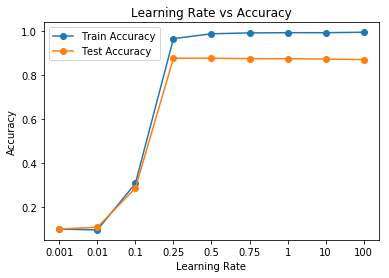

In [46]:
plt.plot(train_acc2, 'o-',label="Train Accuracy")
plt.plot(test_acc2, 'o-',label="Test Accuracy")
plt.legend()
plt.xticks(range(len(LEARNING_RATE)),LEARNING_RATE)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Learning Rate vs Accuracy");

###### Conclusion:

Based on the graph/experiment we can say that the alpha/learning rate of 0.5 seems to give better accuracy and it remains same/slightly lower when the learning rate was increased. Therefore, for the experiments onwards uses alpha=0.5.

* Evaluation of accuracy for different number of epochs

In [47]:
ITERATIONS=[100,200,500,700,1000,1200,1500,2000,2500,3000,4000]
train_acc3, test_acc3 = train_nn([50],lamd=0,iterations=ITERATIONS,activation='logistic',alpha=[0.5])
print(train_acc3,test_acc3)

Training layers:  [785, 50, 10]
Training layers for:  100
Starting gradient descent for 100 iterations
Training layers for:  200
Starting gradient descent for 200 iterations
Training layers for:  500
Starting gradient descent for 500 iterations
Training layers for:  700
Starting gradient descent for 700 iterations
Training layers for:  1000
Starting gradient descent for 1000 iterations
Training layers for:  1200
Starting gradient descent for 1200 iterations
Training layers for:  1500
Starting gradient descent for 1500 iterations
Training layers for:  2000
Starting gradient descent for 2000 iterations
Training layers for:  2500
Starting gradient descent for 2500 iterations
Training layers for:  3000
Starting gradient descent for 3000 iterations
Training layers for:  4000
Starting gradient descent for 4000 iterations
[0.1, 0.198, 0.903, 0.981, 0.991, 0.991, 0.992, 0.994, 0.994, 0.996, 0.996] [0.1, 0.198, 0.842, 0.874, 0.868, 0.872, 0.872, 0.866, 0.868, 0.868, 0.868]


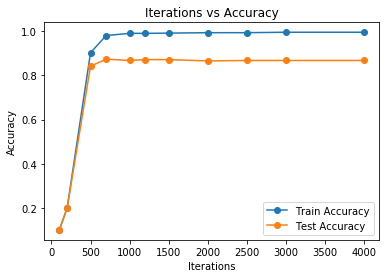

In [48]:
plt.plot(ITERATIONS, train_acc3, 'o-',label="Train Accuracy")
plt.plot(ITERATIONS, test_acc3, 'o-',label="Test Accuracy")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy");

###### Conclusion:

From the experimental graph, we can observe that as the number of iterations/epoch was higher the accuracy increased and became constant after certain level of iterations. We can see after 1500 iterations the model behaves almost similar so for the experiments following this uses 1500 iterations. Additionally, the higher value of the iterations was not selected because it would take longer time to train and it also makes the model prune to overfitting, where the model has seen the data so many times that it starts to overfit the data rather than generalizing the model.

#### 2. Plot network accuracy as a function of the number of hidden units for a two-layer network with a logistic activation function, similarly to part 1 using a specific value of the learning rate and number of epochs. Does this dataset benefit from the use of more than one layer?

##### Answer:

In order to check the performance of the model with 2 hidden layers with various number of hidden units, the following experiment was performed. As the hidden layer for the model (which uses alpha=0.5 with no regularization and logistic activation for 1500 iterations) varies, the accuracy was recorded and present in the graph. We see the model did not perform well (overall) with 2 hidden layers. As we can see the accuracy of the model barely reached 30% on both training and test dataset. The conclusion can be that 2 hidden layers does not perform well with this MNIST dataset. Also from the experiment with the single layer we can say having 1 layer of hidden units is sufficient enough and we won't achieve better results by adding additional layers to our model for this dataset.

In [59]:
hidden_2layers=[(5,5),(10,10),(30,30),(50,10),(50,50),(70,70),(80,50),(100,50),(100,100),(150,150)]
train_2acc, test_2acc = train_nn(hidden_2layers,lamd=0,iterations=[1500],activation='logistic',alpha=[0.5])
print(train_2acc, test_2acc)

Training layers:  [785, 5, 5, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 10, 10, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 30, 30, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 50, 10, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 50, 50, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 70, 70, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 80, 50, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 100, 50, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 100, 100, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 150, 150, 10]
Starting gradient descent for 1500 iterations
[0.1, 0.168, 0.229, 0.197, 0.269, 0.274, 0.25, 0.242, 0.26, 0.217] [0.1, 0.174, 0.222, 0.198, 0.256, 0.266, 0.242, 0.238, 0.26, 0.218]


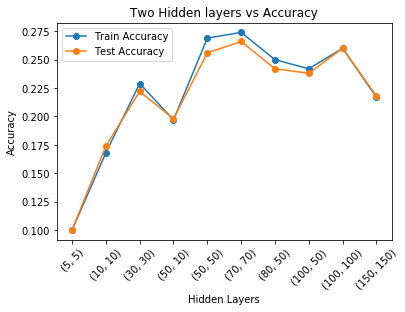

In [60]:
plt.plot(train_2acc, 'o-',label="Train Accuracy")
plt.plot(test_2acc, 'o-',label="Test Accuracy")
plt.legend()
plt.xticks(range(len(hidden_2layers)),hidden_2layers,rotation=45)
plt.xlabel("Hidden Layers")
plt.ylabel("Accuracy")
plt.title("Two Hidden layers vs Accuracy");

#### 3.  Add weight decay regularization to the neural network class (explain in your report how you did it). Does the network demonstrate less over-fitting on this dataset with the addition of weight decay?

#### Answer:

In order to implement the regularization the weight was decayed during the update by the factor of $\lambda$(decay rate).The general idea for regularization is to increment the loss function so that the tries again to minimize the error to finalize the minima. Since updating the error is equivalent to updating the weight, the second approach was followed. Therefore, the equation of the weight update was changed to 

`self.W[l] += -alpha * (1.0/N * delta_W[l]) - lambd*self.W[l]` 

where lambd is the decay factor.

We know that the cost function with regularization is given as Ein = $Ein_0$ + $\frac{\lambda}{N}$$\sum w^2$ where $Ein_0$ is the in sample error without regularization.

Now lets take the derivative of the Ein with respect to w, we get
$$
\frac{\partial Ein}{\partial w}  = \frac{\partial Ein_0}{\partial w} + \frac{2\lambda}{N}w
$$
$$
\frac{\partial Ein}{\partial b}  = \frac{\partial Ein_0}{\partial b}
$$
From backpropogation, the above gradient changed is updated to the weight and bias and the equation of weight becomes:
$$
w = w - \frac{\partial Ein_0}{\partial w} - \frac{2\lambda}{N}w
$$
$$
b = b - \frac{\partial Ein_0}{\partial b}
$$

For simplicity, the change of $Ein_0$ w.r.t bias and weight term was ignored. Therefore we get the final equation as:
$$
w = w - \frac{2\lambda}{N}w
$$

In order to verify if the regularization worked as expected, the experiment was conducted again and we can see in the graph below that as the decay factor is increased the model can't actually learn much out of the dataset and the accuracy is very low. Therefore, it is important to actually find a better decay factor ($\frac{2\lambda}{N}$) so that the model can be prevented from overfitting without affecting the accuracy too much. 

Since the model didn't show the exact overfitting where we could exactly analyze the effect of regularization (by analyzing the unregularized vs regularized accuracies), the conclusion is more subtle. 

###### Conclusion:
As we can see from the graph the gap between the training accuracy and test accuracy has decreased compared to unregularized accuracy graph for single layer.

From the experiment we can see that the training accuracy and test accuracy has a difference of (94.6%-86.8% ~ 8%) for unregularized training.

[0.205, 0.874, 0.948, 0.946, 0.947, 0.945, 0.946] [0.19, 0.796, 0.86, 0.866, 0.86, 0.86, 0.868]

For Regularized training we can see the accuracy difference has reduced to ~5% which can be considered a progress as the model is trying to reduce the training accuracy (which in the other sense means regularization has some effect on the model learning). 

[0.198, 0.808, 0.923, 0.928, 0.932, 0.924, 0.92, 0.919, 0.91] [0.2, 0.788, 0.864, 0.874, 0.872, 0.866, 0.858, 0.862, 0.856]

NOTE: Some additional test for regularization has been added at the bottom of the report under Additional Regularization section.

In [6]:
# Regularization
# train_acc_reg, test_acc_reg = train_nn([50],lamd=0.000001,iterations=[1500],activation='logistic',alpha=[0.5])
# train_acc_reg1, test_acc_reg1 = train_nn([50],lamd=0.01,iterations=[1500],activation='logistic',alpha=[0.5])
# train_acc_reg2, test_acc_reg2 = train_nn([50],lamd=0.00107,iterations=[1500],activation='logistic',alpha=[0.5])
hidden_layers = [2,10,25,50,100,150,200,250,400]
# train_acc_reg, test_acc_reg = train_nn(hidden_layers,lamd=0.0000001,iterations=[1500],activation='logistic')
train_acc_reg1, test_acc_reg1 = train_nn(hidden_layers,lamd=0.5,iterations=[1500],activation='logistic')
train_acc_reg2, test_acc_reg2 = train_nn(hidden_layers,lamd=0.00107,iterations=[1500],activation='logistic')

# print(train_acc_reg,test_acc_reg)
print(train_acc_reg1,test_acc_reg1)
print(train_acc_reg2,test_acc_reg2)


Training layers:  [785, 2, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 10, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 25, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 50, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 100, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 150, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 200, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 250, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 400, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 2, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 10, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 25, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 50, 10]
Starting gradient descent for

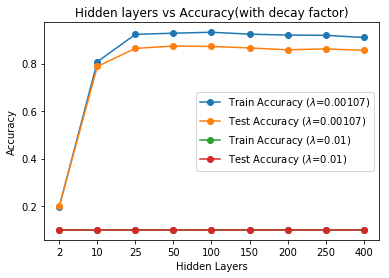

In [7]:
plt.plot(train_acc_reg2, 'o-',label="Train Accuracy ($\lambda$=0.00107)")
plt.plot(test_acc_reg2, 'o-',label="Test Accuracy ($\lambda$=0.00107)")
plt.plot(train_acc_reg1, 'o-',label="Train Accuracy ($\lambda$=0.01)")
plt.plot(test_acc_reg1, 'o-',label="Test Accuracy ($\lambda$=0.01)")
# plt.plot(train_acc_reg, 'o-',label="Train Accuracy ($\lambda$=0.0000001)")
# plt.plot(test_acc_reg, 'o-',label="Test Accuracy ($\lambda$=0.0000001)")
plt.legend()
plt.xticks(range(len(hidden_layers)),hidden_layers)
plt.xlabel("Hidden Layers")
plt.ylabel("Accuracy")
plt.title("Hidden layers vs Accuracy(with decay factor)");

#### 4. Modify the code to include the option of using the cross-entropy loss function instead of the quadratic loss function.  Run experiments and determine which activation function works best with the cross-entropy (consider logistic and ReLU activations for the hidden layers).  Explain in your writeup the required changes in the code.

##### Answer:

In order to include the cross-entropy loss, an andditional function was defined called "calculate_output_layer_delta_xentropy" which computes the loss function with respect to the weight. The equation used in the function was derived using following steps:


The quadratic loss function looks like this: $(y-\hat y)^2$

The equation for Ein we used in the notes looks like this: $\frac{1}{N}\sum_{n=1}^{N}(y_n-x^{(L)})^2$ This has been used to implement the loss function in the code provided. If we check the derivative with respect to weight, we get

$$
\frac{\partial Ein}{\partial w}  =-2(y_i-\hat y_i)\frac{\partial{(y_i-\hat y_i)}}{\partial w}
$$
$$
                                 = -2(y_i-\hat y_i)\frac{\partial y_i}{\partial w}-\frac{\partial \hat y_i}{\partial w}
$$

$$
                                 = -2(y_i-\hat y_i)\frac{\partial\hat y_i}{\partial w}
 $$

The code implements the equation above as `-(y-h_out) * self.activation_deriv(s_out)` where the activation_deriv depends on which activation function is being used. 

Our new loss function looks like this: -$\sum^{C}_{i=1}y_ilog(\hat y_i)$
where,

$y_i$: either 0/1 depending if the example belongs to class i or not

$\hat y_i$: estimated probablity for class i

C: Total number of class (in our MNIST dataset we have 10 class \[0-9\])

Now in order to find the derivative of Ein with respect to weight. Using chain rule for derivative we get
$$
\frac{\partial Ein}{\partial w}  = \sum_{i=1}^{c}\Big(y_i\frac{\partial{log(\hat y_i)}}{\partial w} + log(\hat y_i)\frac{\partial y_i}{\partial w}\Big)
$$
$$
                                 = \sum_{i=1}^{c}\Big(\frac{y_i}{\hat y_i}\frac{\partial{\hat y_i}}{\partial w} + log(\hat y_i)\frac{\partial y_i}{\partial w}\Big)
$$

$$
                                 = \sum_{i=1}^{c}\Big(\frac{y_i}{\hat y_i}\frac{\partial{\hat y_i}}{\partial w}\Big)
 $$
Since $y_i$ can take a value 0 or 1 depending on the class it belongs to the derivative of the constant term is 0 so we ignore that from our calculation.
So we have the signal output which is $\hat y_i$ and the derivative of this is taken with respect to weight. Now we have to use use logistic activation at the output so that we can get the probablity the example is classified into which class. So logistic_deriv method is used to find the signal derivative. Therefore, our overall equation was implemented in the code as mentioned below:

`-np.sum(y/h_out+1e-17) * logistic_deriv(s_out)`

Since we are dealing with division, a very tiny number has been added to the h_out so that division by zero can be prevented.


###### Conclusion:

As we can see when we use cross-entropy with logistic function the method performs poorly giving very minor accuracy of 5.8% on training set and 5.6% on test dataset. However, when the RELU activation was used with cross-entropy the accuracy increased by 8% to 13.7% (train dataset) and 13.6% (test dataset). Though this is not a noticable performance on this dataset. However, we can say as a conclusion that using RELU activation with cross-entropy is a better choice than logistic activation. Nowadays we should use ReLu which should only be applied to the hidden layers as this helps to remove the vanishing Gradient problem seen during the training. 

Therefore, the results through doesn't have much to say it indicates that the RELU should be used compared to logistic for hidden layers and this helps the model to perform better.

In [43]:
train_x_acc, test_x_acc = train_nn([50],lamd=0,iterations=[1500],activation='logistic',xentropy=True,alpha=[0.5])
train_x_acc2, test_x_acc2 = train_nn([50],lamd=0,iterations=[1500],activation='relu',xentropy=True,alpha=[0.5])
print("Accuracies with logistic activation: %s (Training Set); %s (Testing Set)"%(train_x_acc[-1]*100, test_x_acc[-1]*100))
print("Accuracies with RELU     activation: %s (Training Set); %s (Testing Set)"%(train_x_acc2[-1]*100, test_x_acc2[-1]*100))

Training layers:  [785, 50, 10]
Starting gradient descent for 1500 iterations
Training layers:  [785, 50, 10]
Starting gradient descent for 1500 iterations
Accuracies with logistic activation: 11.600000000000001 (Training Set); 12.2 (Testing Set)
Accuracies with RELU     activation: 13.5 (Training Set); 14.399999999999999 (Testing Set)


#### 5. The code provided performs batch gradient descent.  Modify the code to perform stochastic gradient descent.  Explain in your report the change you made, and compare the performance of the resulting network in terms of accuracy and training time.

```python
if stocastic:
    #Shuffle the sample.
    idx=np.random.permutation(range(len(X)))
    X=X[idx]
    y=y[idx] 
    for i in range(len(y)):
        delta = {}
        # perform the feed forward pass and return the stored h and z values, to be used in the
        # gradient descent step
        h, s = self.forward(X[i, :])
        # backpropagate the errors
        for l in range(len(self.architecture), 0, -1):
            if l == len(self.architecture):
                if xentropy:
                    delta[l] = self.calculate_output_layer_delta_xentropy(y[i,:], h[l], s[l])
                else:
                    delta[l] = self.calculate_output_layer_delta(y[i,:], h[l], s[l])
                avg_cost += (np.linalg.norm((y[i,:]-h[l])) / N)
            else:
                if l > 1:
                    delta[l] = self.calculate_hidden_delta(delta[l+1], self.W[l], s[l])

                if stocastic:
                    delta_W[l] = np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis]))
                    delta_b[l] = delta[l+1]
                    self.W[l] += -alpha * delta_W[l] - lambd*self.W[l]
                    self.b[l] += -alpha * delta_b[l]
                else:
                    delta_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis]))
                    delta_b[l] += delta[l+1]

    if not stocastic:
        # perform the gradient descent step for the weights in each layer
        for l in range(len(self.architecture) - 1, 0, -1):
            self.W[l] += -alpha * (1.0/N * delta_W[l]) - lambd*self.W[l]
            self.b[l] += -alpha * (1.0/N * delta_b[l])
```

Above code was the change made to the previous code to add stocastic gradient descent method.

The batch gradient descent method first tries to update the change in W to delta_W for all the training example and then it tries to update the weight. While in stocastic gradient descent the change in W is computed for each example seen by the model and immediately the weight is updated. This helps to minimize the loss quickly than batch gradient descent because the weight is updated for each example/batch(also considered in most of the popular implementations) and this helps to reduce the error in another example the model sees. So it can immediately implement the changes to the weight so that the model can correct itself and adapt to the change.

Additionally, on each pass through the dataset we shuffle the data so that we increase the chance that the model sees different change in the data and updates the gradient more efficiently.

* Comparison of accuracy and execution time:

From the output of the below command we can see that the accuracy for both of the model is similar which is around 87% for test dataset. However the noticiable difference is present in the Cost after 200 iterations. As we can see in the execution output, the cost for stocastic gradient descent for 200 iterations is `Final Cost:  0.02081568774446093` while for the batch gradient descent it is `Final Cost:  0.9343119932052937`. This explains how differen both the algorithms are compared to minimizing the loss. We could see the SGD can achieve the lower cost in very small execution time. The current time for executing all the iterations is similar for both the method as the model has to transverse through the dataset for given number of iterations (which is not the exact comparator we need to focus on). But as suggested before, the cost for SGD has reduced to very lower value in less number of iterations. Therefore, the SGD can give same or better accuracy for lower number of iterations compared to batch gradient descent which means the execution time for SGD is lower compared to its counterpart if we are fouced to achieve the same accuracy.


In [53]:
def train_stocastic(hidden_layer=[30], iterations=[1500],alpha=[0.5]):
    import time
    print("-"*27,"\nStocastic Gradient Descent\n","-"*27)
    start_time=time.time()
    train_s_acc, test_s_acc = train_nn(hidden_layer,lamd=0,iterations=iterations,activation='logistic',xentropy=False,alpha=alpha,stocastic=True)
    end_time = time.time()
    print("Train Accuracy: %s ; Test Accuracy: %s ; Time Taken(sec): %s "%(train_s_acc[-1]*100, test_s_acc[-1]*100,(end_time-start_time)))
    print("-"*27,"\nBatch Gradient Descent\n","-"*27)
    start_time=time.time()
    train_b_acc, test_b_acc = train_nn(hidden_layer,lamd=0,iterations=iterations,activation='logistic',xentropy=False,alpha=alpha,stocastic=False)
    end_time = time.time()
    print("Train Accuracy: %s ; Test Accuracy: %s ; Time Taken(sec): %s "%(train_b_acc[-1]*100, test_b_acc[-1]*100,(end_time-start_time)))

In [54]:
train_stocastic([25],[1000])

--------------------------- 
Stocastic Gradient Descent
 ---------------------------
Training layers:  [785, 25, 10]
Starting gradient descent for 1000 iterations
Final Cost:  0.02081568774446093
Final Cost:  0.015529839875226908
Final Cost:  0.01335980191968715
Final Cost:  0.0121823810485782
Final Cost:  0.011401508800648615
Final Cost:  0.010857184243561017
Final Cost:  0.01044670940632555
Final Cost:  0.010126183130934186
Final Cost:  0.009869794641978173
Train Accuracy: 99.4 ; Test Accuracy: 88.0 ; Time Taken(sec): 139.64163374900818 
--------------------------- 
Batch Gradient Descent
 ---------------------------
Training layers:  [785, 25, 10]
Starting gradient descent for 1000 iterations
Final Cost:  0.9343119932052937
Final Cost:  0.8803721184406582
Final Cost:  0.8091623624649165
Final Cost:  0.6892386541459187
Final Cost:  0.5863823790129173
Final Cost:  0.4939127163510461
Final Cost:  0.42145283182798754
Final Cost:  0.36728256618819577
Final Cost:  0.3264034753063936
Train

#### 6. The provided implementation uses the same activation function in each layer. For solving regression problems we need to use a linear activation function to produce the output of the network. Explain why, and what changes need to be made in the code.

#### Answer:

The use of activation (on a first place) was to make the neural network more efficient so that it can learn the non-linear complex mapping from input features to corresponding label. So it actually helps to add non-linearity properties to the network. The main importance of the activation function is to convert the input signal arrived at the layer to output so that other layer can consume for generating further outputs.

Now if the activation function is not applied to the hidden layers/any layers at all then it is simply asking the neural network to use the linear function (i.e one degree polynomial function). 

For example:
Suppose we feed a network with x as input which has some number of features in it. Suppose we have a two layer hidden layer with weight $W_1$ and $W_2$ with bias term B1 and B2. Lets represent the computation in each layers without any activation function:

$$
Output (1-layer) = W_1*x + B_1
$$
The output of first layer is the input to the second layer.
$$
Output (2-layer) = W_2(W_1*x + B_1) + B_2\\
                 = W_2*W_1*x + W_2*B_1 + B_2\\
                 = W_2*W_1*x + B_3 \:\:\:..................(1)
$$
So we finally end up with the equation (1) present above which is a linear equation. Therefore, if the requirement is to implement the linear activation function then we can simply not apply any activation function as the default nature of the neural network without activation is "linear".

Therefore, if we have to implement the linear functionality in the above code we can simply remove the use of activation function and just consider the input to the layer mutiply with weight add up the bias of that layer and then push the output generated to the next layer.

However, it is important to note that if the activation is linear then adding multiple layers is not going to improve the model performance as adding multiple layers is equivalent to a single layer with different weight and bias vector values (as a combination of linear function is equivalent to a single linear function).


### Additional Test for Regularization: (Optional)

In [12]:
# Part-3
accuracies=[]
INPUT_LAYER=785
OUTPUT_LAYER=10
ITERATIONS=1600
hidden_layers=[2,10,50,100,150,200,250]
train_acc=[]
for i in hidden_layers:
    architecture = [INPUT_LAYER,i , OUTPUT_LAYER]
    print("Training layers: ", architecture)
    network = NeuralNetwork(architecture, 'logistic')
    cost_func = network.fit(X_ntrain, y_vec_train, ITERATIONS,alpha=0.25,lambd=0.002)
    y_pred = network.predict(X_ntest)
    y_pd = network.predict(X_ntrain)
    print("Test UNIQ: ",np.unique(y_pred))
    print("Train UNIQ: ",np.unique(y_pd))
#     print("Weight: ",network.W)
    accuracies.append(accuracy_score(y_test, y_pred))
    train_acc.append(accuracy_score(y_train,y_pd))
    print("Train ACC: ",accuracy_score(y_train,y_pd))
    print("Test ACC: ",accuracies)

Training layers:  [785, 2, 10]
Starting gradient descent for 1600 iterations
Iteration 0 of 1600
Iteration 400 of 1600
cost:  0.9533320579212544
Iteration 800 of 1600
cost:  0.9514025141628125
Iteration 1200 of 1600
cost:  0.9502263515018764
Test UNIQ:  [6. 9.]
Train UNIQ:  [6. 9.]
Train ACC:  0.179
Test ACC:  [0.176]
Training layers:  [785, 10, 10]
Starting gradient descent for 1600 iterations
Iteration 0 of 1600
Iteration 400 of 1600
cost:  0.9509183332441711
Iteration 800 of 1600
cost:  0.9490819328658049
Iteration 1200 of 1600
cost:  0.9319704520639597
Test UNIQ:  [0. 3. 6. 7. 9.]
Train UNIQ:  [0. 3. 4. 6. 7. 9.]
Train ACC:  0.343
Test ACC:  [0.176, 0.334]
Training layers:  [785, 50, 10]
Starting gradient descent for 1600 iterations
Iteration 0 of 1600
Iteration 400 of 1600
cost:  0.9485761772323927
Iteration 800 of 1600
cost:  0.9273033134941053
Iteration 1200 of 1600
cost:  0.7994305589118019
Test UNIQ:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Train UNIQ:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]

In [17]:
def train_nn(hidden_layers=[2,10,50,100,150,200,250],iterations=1600,alpha=0.25, lambd=0.0015,activation='logistic'):
    # Part-3
    X_train,y_train,X_test,y_test = mnist_loader()
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.metrics import accuracy_score
    from sklearn import preprocessing
    y_vec_train=LabelBinarizer().fit_transform(y_train)
    X_ntrain=preprocessing.scale(X_train)
    X_ntest=preprocessing.scale(X_test)
    X_ntrain = np.hstack((np.ones((X_ntrain.shape[0],1)),X_ntrain))
    X_ntest = np.hstack((np.ones((X_ntest.shape[0],1)),X_ntest))
    test_acc=[]
    INPUT_LAYER=785
    OUTPUT_LAYER=10
    train_acc=[]
    for i in hidden_layers:
        architecture = [INPUT_LAYER,i , OUTPUT_LAYER]
        print("Training layers: ", architecture)
        network = NeuralNetwork(architecture, activation)
        cost_func = network.fit(X_ntrain, y_vec_train, num_iterations=iterations,alpha=alpha,lambd=lambd)
        y_pred = network.predict(X_ntest)
        y_pd = network.predict(X_ntrain)
        print("Test UNIQ: ",np.unique(y_pred))
        print("Train UNIQ: ",np.unique(y_pd))
        test_acc.append(accuracy_score(y_test, y_pred))
        train_acc.append(accuracy_score(y_train,y_pd))
        print("Train ACC: ",accuracy_score(y_train,y_pd))
        print("Test ACC: ",test_acc)
    return train_acc, test_acc

In [18]:
train_acc,test_acc=train_nn(lambd=0.0015)

Training layers:  [785, 2, 10]
Starting gradient descent for 1600 iterations
Iteration 0 of 1600
Iteration 400 of 1600
cost:  0.95158778324047
Iteration 800 of 1600
cost:  0.9502346037806553
Iteration 1200 of 1600
cost:  0.9478709464920229
Test UNIQ:  [3. 6.]
Train UNIQ:  [3. 6.]
Train ACC:  0.185
Test ACC:  [0.18]
Training layers:  [785, 10, 10]
Starting gradient descent for 1600 iterations
Iteration 0 of 1600
Iteration 400 of 1600
cost:  0.9498418586526773
Iteration 800 of 1600
cost:  0.9414859397548435
Iteration 1200 of 1600
cost:  0.9142073444667056
Test UNIQ:  [0. 1. 2. 3. 4. 6. 7.]
Train UNIQ:  [0. 1. 2. 3. 4. 6. 7.]
Train ACC:  0.539
Test ACC:  [0.18, 0.516]
Training layers:  [785, 50, 10]
Starting gradient descent for 1600 iterations
Iteration 0 of 1600
Iteration 400 of 1600
cost:  0.9486715915748949
Iteration 800 of 1600
cost:  0.9160084520238087
Iteration 1200 of 1600
cost:  0.7802350195181756
Test UNIQ:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Train UNIQ:  [0. 1. 2. 3. 4. 5. 6. 7. 8

In [19]:
train_acc2,test_acc2=train_nn(lambd=0.0012,iterations=2000)

Training layers:  [785, 2, 10]
Starting gradient descent for 2000 iterations
Iteration 0 of 2000
Iteration 400 of 2000
cost:  0.9512811299357904
Iteration 800 of 2000
cost:  0.9502971970147267
Iteration 1200 of 2000
cost:  0.9496941362110161
Iteration 1600 of 2000
cost:  0.9478283193870747
Test UNIQ:  [0. 1.]
Train UNIQ:  [0. 1.]
Train ACC:  0.197
Test ACC:  [0.2]
Training layers:  [785, 10, 10]
Starting gradient descent for 2000 iterations
Iteration 0 of 2000
Iteration 400 of 2000
cost:  0.9492427463137191
Iteration 800 of 2000
cost:  0.9463624668664411
Iteration 1200 of 2000
cost:  0.9204370714798543
Iteration 1600 of 2000
cost:  0.8538076679948828
Test UNIQ:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Train UNIQ:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Train ACC:  0.761
Test ACC:  [0.2, 0.734]
Training layers:  [785, 50, 10]
Starting gradient descent for 2000 iterations
Iteration 0 of 2000
Iteration 400 of 2000
cost:  0.9482135935498639
Iteration 800 of 2000
cost:  0.899597736964078
Iteration 1200 of

### Your Report

Answer the questions in the cells reserved for that purpose.

Mathematical equations should be written as LaTex equations; the assignment contains multiple examples of both inline formulas (such as the one exemplifying the notation for the norm of a vector $||\mathbf{x}||$ and those that appear on separate lines, e.g.:

$$
||\mathbf{x}|| = \sqrt{\mathbf{x}^T \mathbf{x}}.
$$



### Submission

Submit your report as a Jupyter notebook via Canvas.  Running the notebook should generate all the plots and results in your notebook.


### Grading 

Here is what the grade sheet will look like for this assignment.  A few general guidelines for this and future assignments in the course:

  * Your answers should be concise and to the point.  We will take off points if that is not the case.
  * Always provide a description of the method you used to produce a given result in sufficient detail such that the reader can reproduce your results on the basis of the description.  You can use a few lines of python code or pseudo-code.


Grading sheet for the assignment:

```
Neural networks.
(15 points):  Exploration of a network with a single hidden layer
(15 points):  Exploration of a network with two hidden layers
(15 points):  Regularization
(20 points):  Cross-entropy
(20 points):  Stochastic gradient descent
(15 points):  Linear activation function for regression
```

Grading will be based on the following criteria:

  * Correctness of answers to math problems
  * Math is formatted as LaTex equations
  * Correct behavior of the required code
  * Easy to understand plots 
  * Overall readability and organization of the notebook
  * Effort in making interesting observations where requested.
  * Conciseness.  Points may be taken off if the notebook is overly 
  